In [5]:
import pandas as pd
import os
import networkx as nx
from matplotlib.pyplot import figure

In [6]:
# NB: Don't forget to run all the scripts prior to this step.
# Load all inputs
df_raw = pd.read_csv('../data/answers.csv',error_bad_lines=False)

In [7]:
# check
df_raw.head()

,Timestamp,Current URL,Player,Guess
0,2021/01/14 11:20:26 PM GMT+1,URL11,Player1,Player2
1,2021/01/14 11:21:25 PM GMT+1,URL11,Player2,Player10
2,2021/01/14 11:21:45 PM GMT+1,URL11,Player7,Player1
3,2021/01/14 11:22:01 PM GMT+1,URL11,Player8,Player11
4,2021/01/14 11:22:21 PM GMT+1,URL11,Player6,Player1


In [10]:
G = nx.from_pandas_edgelist(df_raw, 'Player', 'Guess')

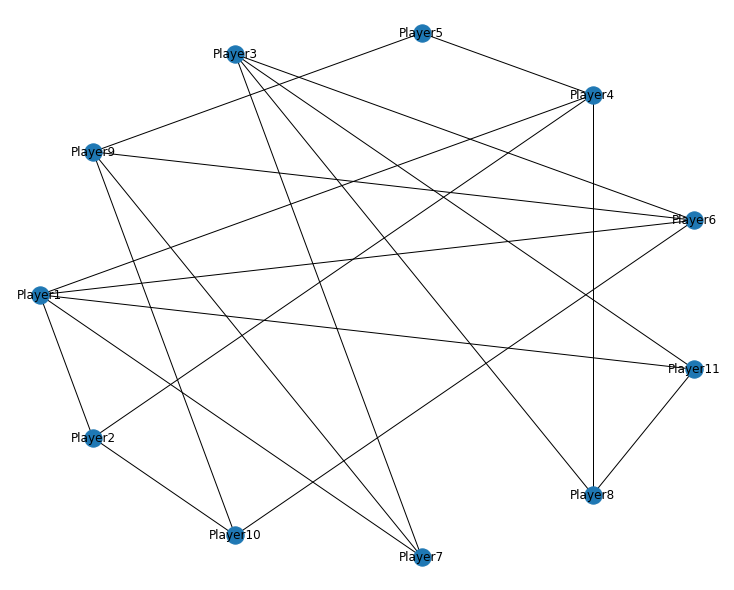

In [11]:
# check viz
# TODO: add per URL

figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)

In [12]:
# code from https://towardsdatascience.com/from-dataframe-to-network-graph-bbb35c8ab675
# create a leaderboard
# this is total stats, TODO: add per URL

leaderboard = {}
for x in G.nodes:
    leaderboard[x] = len(G[x])
    s = pd.Series(leaderboard, name='connections')
    df2 = s.to_frame().sort_values('connections', ascending=False)
df2.head()

,connections
Player1,5
Player6,4
Player4,4
Player3,4
Player9,4
